# Multi-class change detection using image segmentation deep learning models

> * 🔬 Data Science
> * 🥠 Deep Learning and image segmentation

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export training data](#Export-training-data)
* [Prepare the data](#Prepare-the-data)
* [Train change detection model](#Train-change-detection-model)
  * [Load UNet model architecture](#Load-UNet-model-architecture)
  * [Tune for optimal learning rate](#Tune-for-optimal-learning-rate)
  * [Fit the model](#Fit-the-model)
  * [Visualize results](#Visualize-results)
  * [Save the model](#Save-the-model)
* [Model inferencing](#Model-inferencing)
  * [Generate change raster utilizing Classify Pixels Using Deep Learning tool](#Generate-change-raster-utilizing-Classify-Pixels-Using-Deep-Learning-tool)
  * [Visualize change map](#Visualize-change-map)
* [Conclusion](#Conclusion)
* [References](#References)

# Introduction

Change detection is used in global remote sensing to find out changes in landcover over a period of time by natural/man-made activities over a wide area in many applications including environmental monitoring, disaster evaluation, and urban expansion studies. Current change detection methods typically follow one of two approaches, utilising either post-classification analysis,or difference image analysis. These methods are often resource-heavy and time intensive. 

In this notebook, we will show a novel way to detect and classify change using semantic segmentation models available in `arcgis.learn`. For more details about the image segmentation model and its working refer [How U-net works?](https://developers.arcgis.com/python/guide/how-unet-works/) in the guide section.

## Necessary imports

In [1]:
import os, zipfile
from pathlib import Path
from os import listdir
from os.path import isfile, join

from arcgis import GIS
from arcgis.learn import prepare_data, PSPNetClassifier, UnetClassifier, DeepLab

## Connect to your GIS

In [15]:
gis = GIS('Home')
ent_gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

## Export training data

For this use case, we have landsat-7 imageries and a classified change map with class information between two time periods i.e. from 2001 to 2016, collected over Egypt with spatial resolution of 30 m. We will export the data in “Classified_tiles” metadata format available in the `Export Training Data For Deep Learning` tool. The tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

For the model to identify changes between imageries, we will build a composite imagery from two different time periods using the [composite](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/composite-bands.htm) tool in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview). It will be provided as `Input Raster` to the model, and the change map will be provided as labels.

- `Input Raster`: Composite_imagery_2001_2016
- `Input feature class or classified raster`: change_map_2001_2016
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Meta Data Format`: 'Classified Tiles' as we are training a segmentation model.
- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

The rasters used for exporting the training dataset are provided below

In [16]:
landsat_composite_2001_16 = ent_gis.content.get('dbe2221e4e1240e986586f0eb3a1479b')
landsat_composite_2001_16

<Item title:"train_area_landsat_composite_2001_16" type:Imagery Layer owner:api_data_owner>

In [17]:
landsat_changemap_2001_16 = ent_gis.content.get('8eef999714d64e9f9494030b9c5f76c2')
landsat_changemap_2001_16

<Item title:"train_area_changemap_tif" type:Imagery Layer owner:api_data_owner>

<div style="align: center; text-align:center; line-height: 5em">
    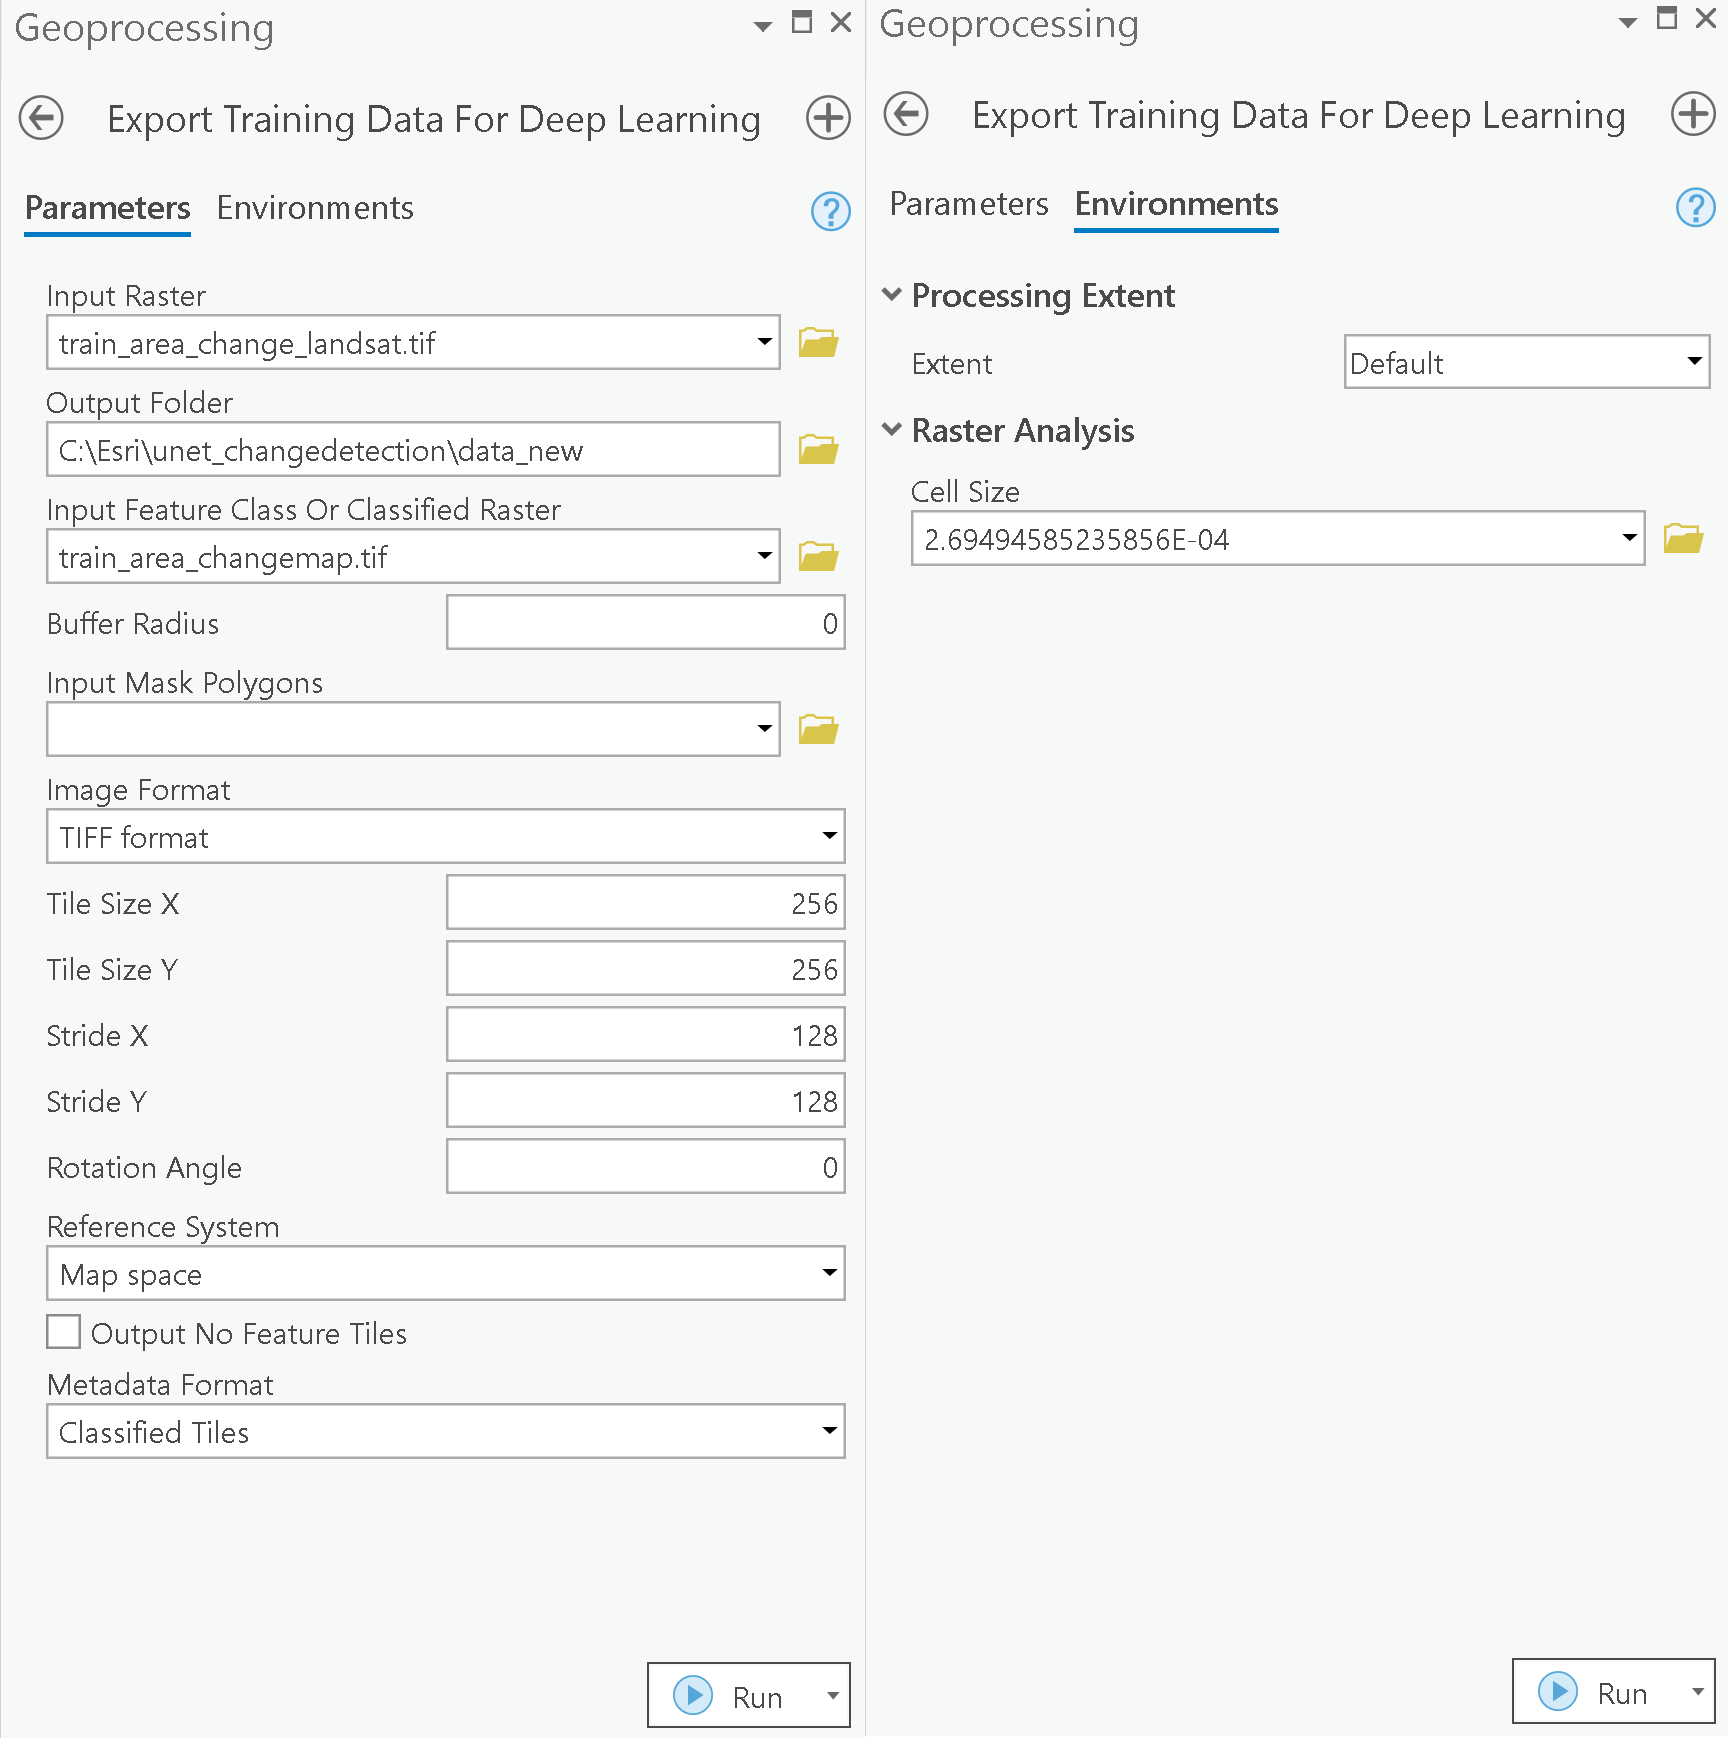 
    <div class="caption"> Export Training Data for Deep Learning tool</div>
</div>

## Prepare the data

Alternatively, we have provided a subset of training data containing a few samples with the rasters used for exporting the training dataset. You may use the data directly to carry out the experiments.

<Item title:"multi_change_detection_dataset" type:Image Collection owner:api_data_owner>
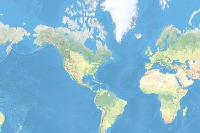

In [6]:
training_data = gis.content.get('3aedfa7e790541a79730eb1db47ed419')
training_data

In [7]:
filepath = training_data.download(file_name=training_data.name)

In [8]:
#Extract the data from the zipped image collection

with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [9]:
data=prepare_data(path=Path(filepath).parent, batch_size=2)

### Visualize a few samples from your training data

To get a sense of about the training data, we will use the `show_batch()` method in `arcgis.learn`. This method randomly picks a few training chips overlayed by their respective labels and visualizes them.

- `alpha`: Opacity of overlayed labels over the training chips

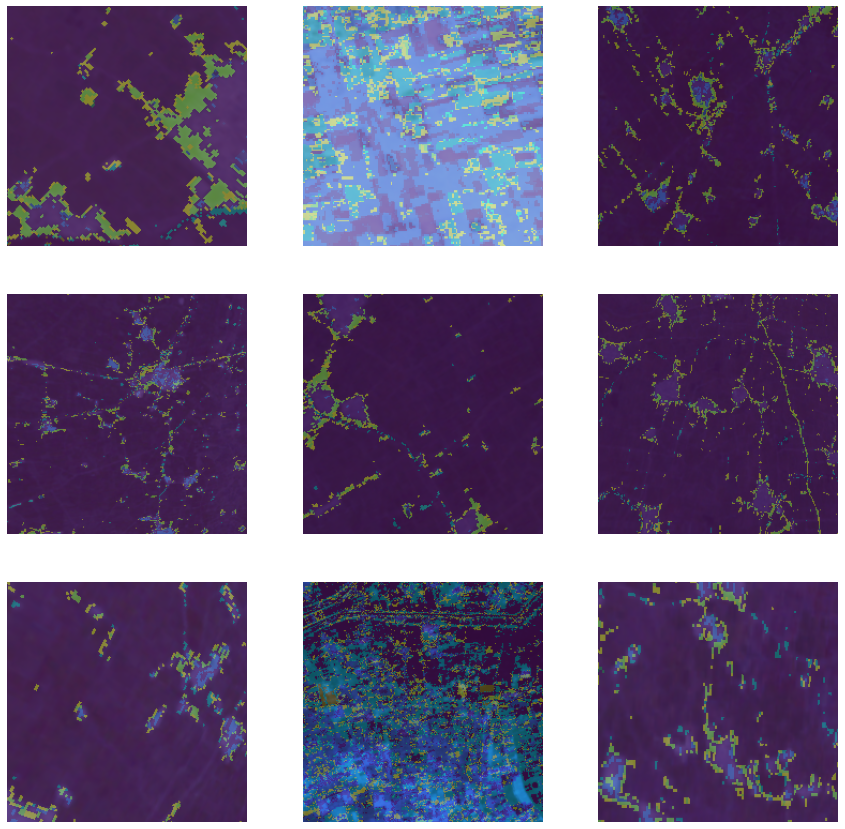

In [3]:
data.show_batch(alpha=0.7)

## Train change detection model

### Load UNet model architecture

In [4]:
model = UnetClassifier(data)

### Tune for optimal learning rate

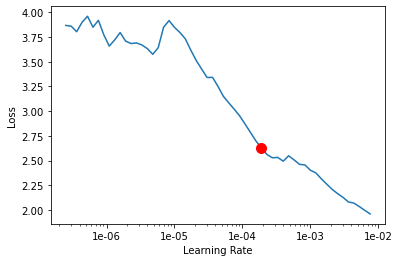

In [5]:
lr = model.lr_find()

### Fit the model

To train the model, we use the `fit()` method. To start, we will train our model for 10 epochs. Epoch defines how many times model is exposed to entire training set.

- `epochs`: Number of cycles of training on the data.
- `lr`: Learning rate to be used for training the model.

In [6]:
model.fit(10, lr)

Here, with 10 epochs, we can see reasonable results — both training and validation losses have decreased significantly, indicating that the model is learning to detect changes.

### Visualize results

It is a good practice to visualize the results obtained from the model with the actual ground truth data. The show_results function picks random samples and visualize the ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

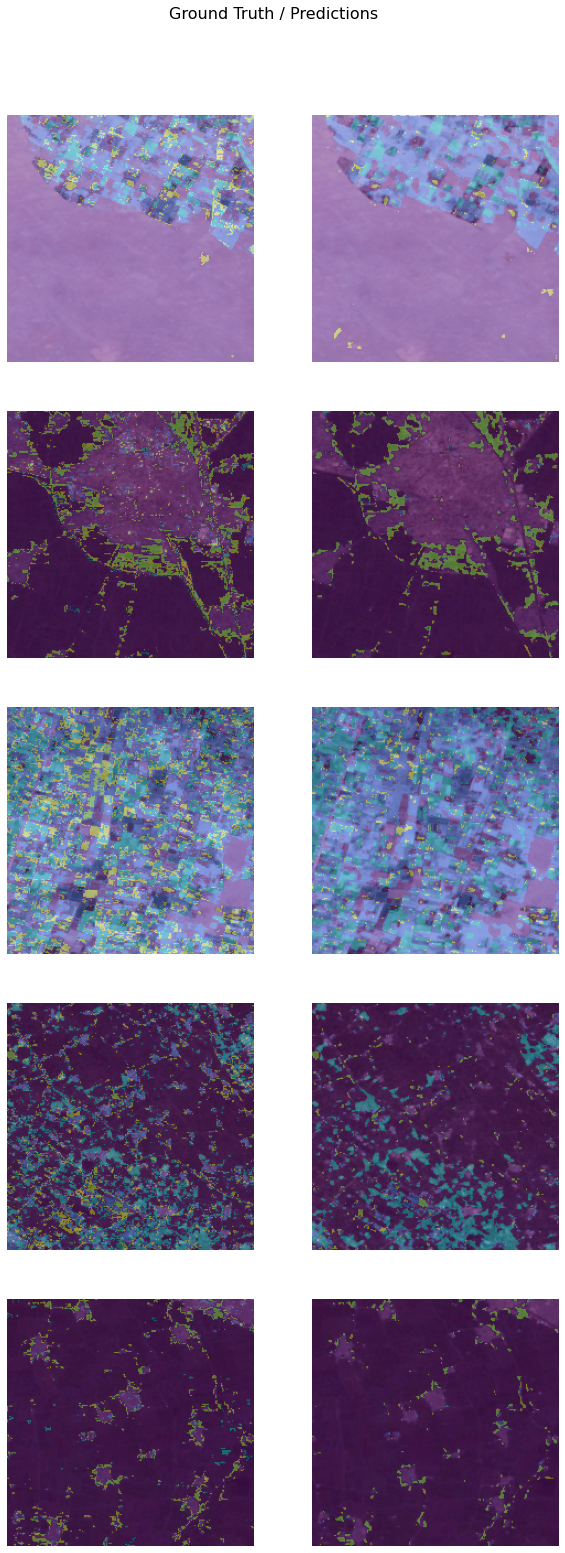

In [7]:
model.show_results()

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to a sub-folder inside the training data folder with the name "models".

In [ ]:
model.save(r'unet_change_model_e10')

### Compute model metrics

In [19]:
model.accuracy()

0.8944873809814453

## Model inferencing

### Generate change raster utilizing Classify Pixels Using Deep Learning tool

After we trained the change detection model and saved the weights for detecting changes. we could use the `Classify Pixels Using Deep Learning` tool available in both [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Enterprise](https://www.esri.com/en-us/arcgis/products/arcgis-enterprise/overview) for inferencing at scale.

In [29]:
test_data = ent_gis.content.get('8e0ca6e7cefb45289eccc0e7ae2c9bfd')
test_data

<Item title:"test_area_change_landsat_tif" type:Imagery Layer owner:api_data_owner>

<div style="align: left; text-align:center; line-height: 5em">
    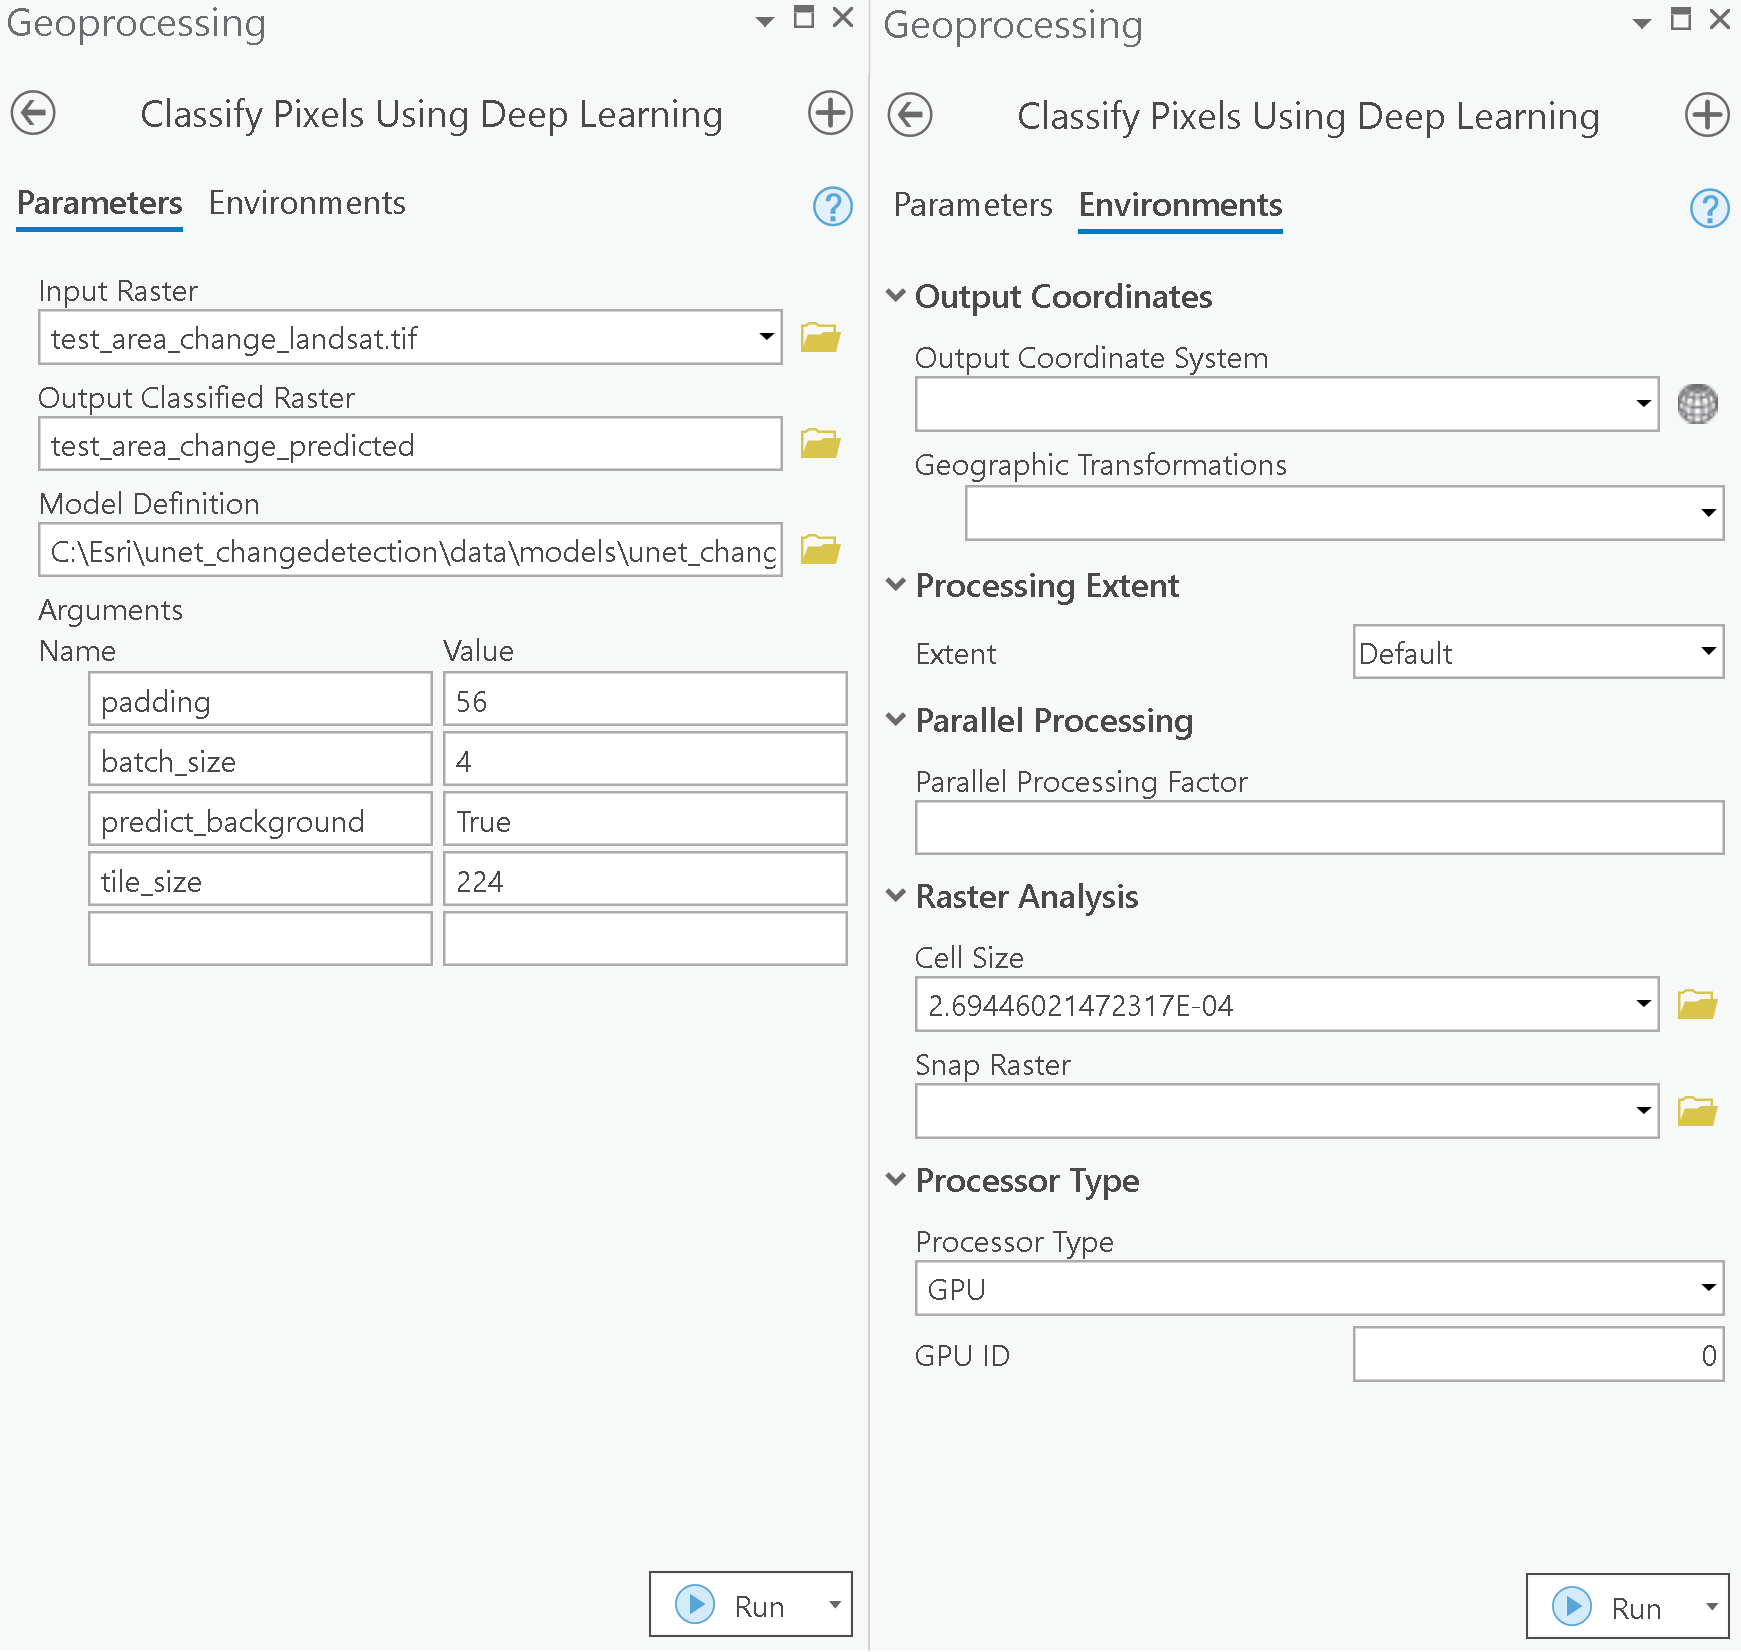
    <div class="caption">Classify Pixels Using Deep Learning tool</div>
</div>

`with arcpy.EnvManager(cellSize=0.0002694460214, processorType='GPU', gpuId = '0'):`


`out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("test_area_change_landsat.tif", r"C:\Esri\unet_multiclass_change\models\model.emd", "padding 56;batch_size 4;predict_background True;tile_size 224")`

`out_classified_raster.save(r"C:\Esri\unet_multiclass_change\test_area_change_predicted.tif")`

### Visualize change map

The below predicted image on test area indicates the area changed along with the final class it converted into.

<div style="align: left; text-align:center;line-height: 5em">
    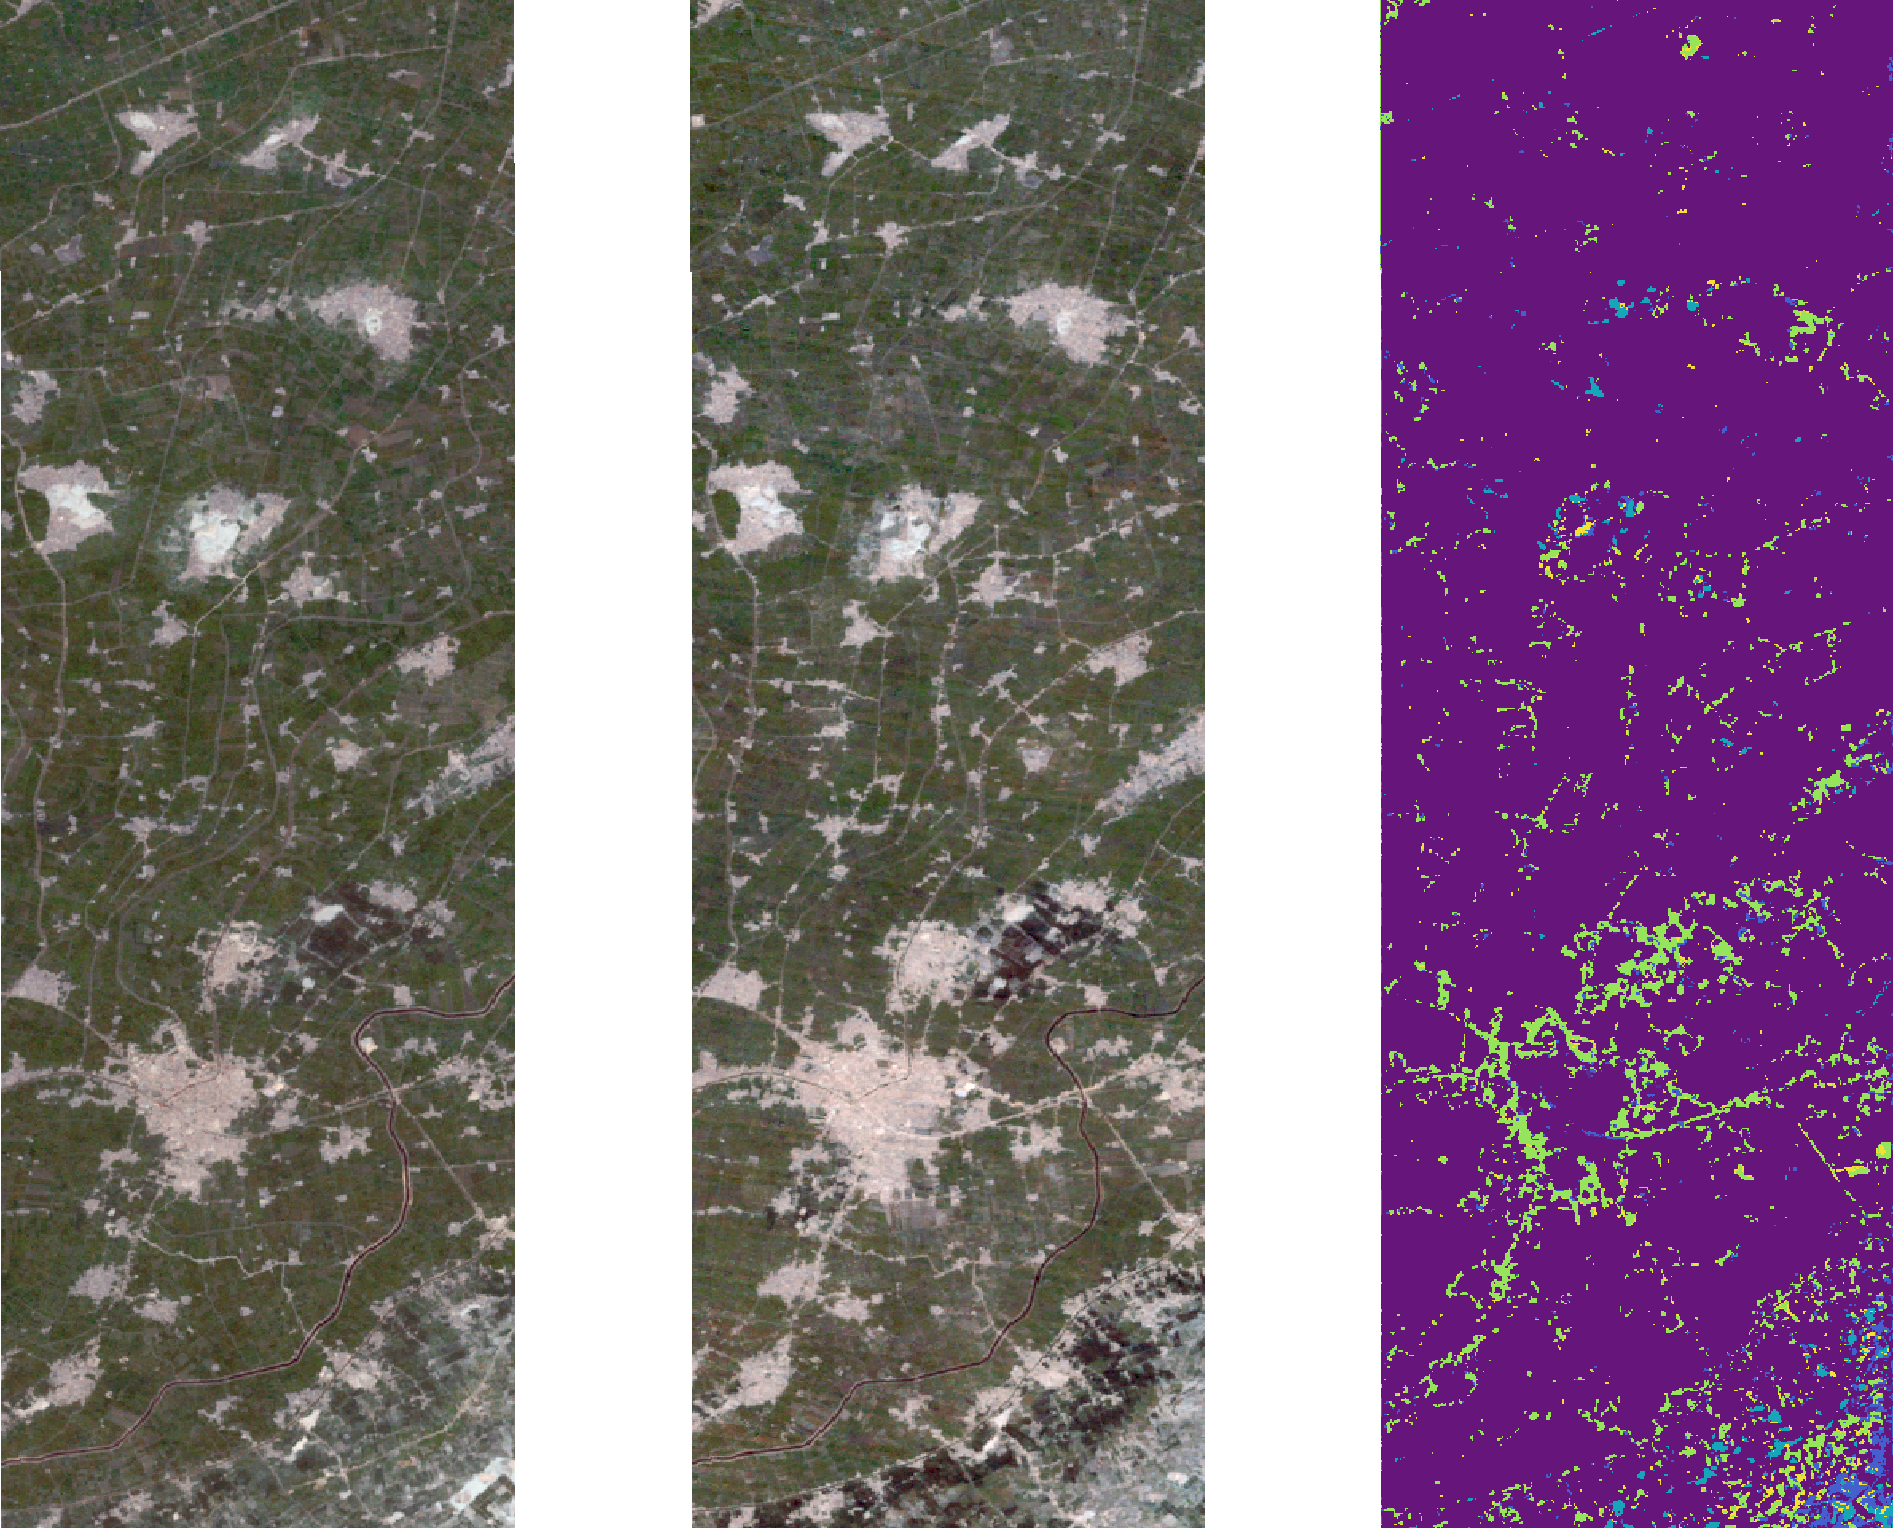
    <div class="caption"> 2011, 2016 and Predicted change from 2011 to 2016 </div>
</div>

## Conclusion

In this notebook, we demonstrated how to use image segmentation models i.e. U-Net, DeepLab, PSPNet available in `arcgis.learn` in order to detect multi-class changes between imageries of two time-period.

## References

[1] Olaf Ronneberger, Philipp Fischer, Thomas Brox: U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015;[arXiv:1505.04597](https://arxiv.org/abs/1505.04597) 